# Исследование моделей атрибуцией

**Цель**: Узнать эффективность рекламных кампаний при разных моделей атрибуции

In [1]:
# импорт библиотек

import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np

In [2]:
plt.rcParams["figure.figsize"] = (12,4) # размер графиков для всего блокнота
plt.style.use('fivethirtyeight') # предустановленный стиль

In [3]:
costs = pd.read_excel('costs_gb.xlsx')
costs.head()

,Date,campaign,google / cpc,yandex / cpc,vkontakte / cpc
0,2011-08-14,brand,90.502456,867.021322,991.528339
1,2011-02-25,not_brand,135.212379,187.313178,991.131532
2,2011-10-28,brand,882.106940,415.945856,980.627513
3,2011-03-12,not_brand,569.433076,154.000000,977.369726
4,2011-04-18,brand,239.069371,202.209591,974.728406


Описание датасета

- Date — дата 
- google / cpc — расход с НДС по Google Ads
- vkontakte / cpc — расход с НДС по рекламе Вконтакте
- yandex / cpc — расход с НДС по рекламе Яндекс Директ
- campaign — название рекламной кампании, всего 2 типа:
-- brand — брендовые* кампании
-- not_brand  — не брендовые кампании

In [4]:
orders = pd.read_excel('order_gb.xlsx')
orders.head()

,client_id,Order ID,Order Date,Order Quantity,Sales,Discount,Ship Mode,Profit,Unit Price,Shipping Cost,Region,Product Category,Product Sub-Category,Product Name,Ship Date
0,2b97454da406955ec40c097647e38316,130,2011-05-07,3,461.8900,0.05,Express,-309.82,150.98,13.99,Saint-Petersburg,Technology,Office Machines,Canon MP41DH Printing Calculator,2012-05-09
1,2b97454da406955ec40c097647e38316,130,2011-05-07,29,575.1100,0.02,Express,71.75,18.97,9.03,Saint-Petersburg,Office Supplies,Paper,Computer Printout Paper with Letter-Trim Perfo...,2012-05-08
2,2b97454da406955ec40c097647e38316,130,2011-05-07,23,236.4600,0.05,Express,-134.31,9.71,9.45,Saint-Petersburg,Office Supplies,Storage & Organization,Filing/Storage Totes and Swivel Casters,2012-05-10
3,59ca19169a2d00aa2466bb9c518a99e7,166,2011-09-11,10,567.9360,0.02,Express,-126.09,65.99,8.99,Moscow,Technology,Telephones and Communication,i270,2011-09-13
4,19d90e0481d1d33e94c2bd99e7d4b3fd,416,2011-09-26,20,1156.6715,0.01,Express,88.52,65.99,7.69,Moscow,Technology,Telephones and Communication,5190,2010-10-01


Описание датасета:

- client_id — уникальный идентификатор пользователя
- Order ID — номер заказа
- Order Date — дата заказа
- Order Quantity — количество товаров
- Discount — размер скидки
- Ship Mode — способ доставки
- Profit — прибыль

In [5]:
sessions = pd.read_excel('session_gb.xlsx')
sessions.head()

,client_id,SessionDate,Order ID,transaction,source / medium,campaign
0,773d6b617bbb589c5f373eebfb98f430,2011-01-19,66.0,1.0,vkontakte / cpc,brand
1,2b97454da406955ec40c097647e38316,2011-05-07,130.0,1.0,google / cpc,brand
2,9b9af30dafdb2f827a5d1098b1d10bc6,2011-06-10,NaN,0.0,vkontakte / cpc,brand
3,846335022b0136cd5887a776adf52071,2011-04-04,194.0,1.0,yandex / cpc,brand
4,c540ae9b2e26fd2a332e1cd3a55debd9,2011-03-25,323.0,1.0,vkontakte / cpc,brand


Описание датасета: 
    
- client_id — уникальный идентификатор пользователя
- SessionDate — дата сессии
- Order ID — номер заказа
- transaction — была ли транзакция во время сессии. Содержит 2 атрибута:
-- 1 — да
-- 0 — нет
- source / medium — medium источник трафика
- campaign — тип рекламной кампании


# Предобработка

In [6]:
# заменяем название колонок на те, с которыми удобно работать

costs_columns = []

for x in costs.columns:
    x = str.lower(x).replace(' ','_')
    costs_columns.append(x)

costs.columns = costs_columns


sessions_columns = []

for x in sessions.columns:
    x = str.lower(x).replace(' ','_')
    sessions_columns.append(x)

sessions.columns = sessions_columns


orders_columns = []

for x in orders.columns:
    x = str.lower(x).replace(' ','_')
    orders_columns.append(x)

orders.columns = orders_columns

In [7]:
for element in [costs, sessions, orders]:
    print(element.info())
    print('-----\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             730 non-null    datetime64[ns]
 1   campaign         730 non-null    object        
 2   google_/_cpc     730 non-null    float64       
 3   yandex_/_cpc     730 non-null    float64       
 4   vkontakte_/_cpc  730 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 28.6+ KB
None
-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19080 entries, 0 to 19079
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   client_id        19080 non-null  object        
 1   sessiondate      19080 non-null  datetime64[ns]
 2   order_id         4723 non-null   float64       
 3   transaction      18107 non-null  float64       
 4   source_/_m

In [8]:
# изменяем тип данных для связывания

orders['order_id'] = orders['order_id'].astype('str')
sessions['order_id'] = sessions['order_id'].astype('str').str.replace(r'\.0','') # fix для float

In [9]:
# проверяем на дубликаты

sessions[(sessions['order_id']!='nan')&(sessions['order_id'].duplicated(keep=False))].sort_values('order_id')

,client_id,sessiondate,order_id,transaction,source_/_medium,campaign


In [10]:
# проверяем соответствие количества заказов

sessions[(sessions['order_id']!='nan')]['order_id'].nunique() == orders['order_id'].nunique()

True

# Вопросы для исследования

1. Какой из каналов принес наибольший profit?
2. Постройте график по дням по цене клика для каждой из систем, учитывая, что цена клика в течение дня не меняется.
3. Рассчитайте средний ROI по месяцам для каждой из рекламных систем.


## Какой из каналов принес наибольший profit?

In [11]:
print(f'Общий профит: {orders.profit.sum():.0f} y.e.')

Общий профит: 1234937 y.e.


In [12]:
# группируем датасет с заказами по № заказов

orders_group_order = orders.groupby('order_id')['profit'].sum().reset_index()
orders_group_order.shape

(4723, 2)

In [13]:
orders_group_order.head()

,order_id,profit
0,10022,-3.88
1,10048,76.51
2,10052,-89.47
3,10053,-305.93
4,10054,-458.35


In [14]:
orders_group_order.profit.sum()  # проверяем сумму профита

1234937.03

In [15]:
# добавляем профит к сессиям

df = pd.merge(sessions, orders_group_order, on='order_id', how='outer')
df.profit.sum()

1234937.0299999998

In [16]:
# сортируем цепочку визитов пользователя

df = df.sort_values(['client_id','sessiondate','order_id']).reset_index(drop=True)
df.head()

,client_id,sessiondate,order_id,transaction,source_/_medium,campaign,profit
0,00039fbdd03f38f626f9b1762e10b31a,2011-04-14,nan,0.0,sendpulse / email,news,NaN
1,00039fbdd03f38f626f9b1762e10b31a,2011-04-17,nan,0.0,direct,NaN,NaN
2,00039fbdd03f38f626f9b1762e10b31a,2011-04-20,38117,1.0,direct,NaN,-128.89
3,00039fbdd03f38f626f9b1762e10b31a,2011-06-05,nan,0.0,mail / organic,NaN,NaN
4,00039fbdd03f38f626f9b1762e10b31a,2011-06-08,nan,0.0,yandex / cpc,brand,NaN


In [17]:
# создаем новое поле с номером заказа, который принадлежит транзакционной цепочке

df['order_id'] = df['order_id'].replace('nan', np.NaN)
df['orders_chain'] = df['order_id'].fillna(method='bfill') 

# создаем новое поле с суммой заказа, который принадлежит транзакционной цепочке

df['profit'] = df['profit'].replace('nan', np.NaN)
df['profits_chain'] = df['profit'].fillna(method='bfill')
df.head()

,client_id,sessiondate,order_id,transaction,source_/_medium,campaign,profit,orders_chain,profits_chain
0,00039fbdd03f38f626f9b1762e10b31a,2011-04-14,NaN,0.0,sendpulse / email,news,NaN,38117,-128.89
1,00039fbdd03f38f626f9b1762e10b31a,2011-04-17,NaN,0.0,direct,NaN,NaN,38117,-128.89
2,00039fbdd03f38f626f9b1762e10b31a,2011-04-20,38117,1.0,direct,NaN,-128.89,38117,-128.89
3,00039fbdd03f38f626f9b1762e10b31a,2011-06-05,NaN,0.0,mail / organic,NaN,NaN,43874,-161.21
4,00039fbdd03f38f626f9b1762e10b31a,2011-06-08,NaN,0.0,yandex / cpc,brand,NaN,43874,-161.21


### Моно-канальные модели атрибуции

#### First Click

In [18]:
df_first_click = df.groupby('orders_chain')['source_/_medium'].first().reset_index() # подставляем первый источник в транзакционной цепочке
df_first_click.columns = ['order_id','first_channel']
df_first_click.head()

,order_id,first_channel
0,10022,vkontakte / cpc
1,10048,mail / organic
2,10052,sendpulse / email
3,10053,mail / organic
4,10054,mail / organic


In [19]:
df = df.merge(df_first_click, on='order_id', how='left')
df.shape

(19080, 10)

In [20]:
df.head(10)

,client_id,sessiondate,order_id,transaction,source_/_medium,campaign,profit,orders_chain,profits_chain,first_channel
0,00039fbdd03f38f626f9b1762e10b31a,2011-04-14,NaN,0.0,sendpulse / email,news,NaN,38117,-128.89,NaN
1,00039fbdd03f38f626f9b1762e10b31a,2011-04-17,NaN,0.0,direct,NaN,NaN,38117,-128.89,NaN
2,00039fbdd03f38f626f9b1762e10b31a,2011-04-20,38117,1.0,direct,NaN,-128.89,38117,-128.89,sendpulse / email
3,00039fbdd03f38f626f9b1762e10b31a,2011-06-05,NaN,0.0,mail / organic,NaN,NaN,43874,-161.21,NaN
4,00039fbdd03f38f626f9b1762e10b31a,2011-06-08,NaN,0.0,yandex / cpc,brand,NaN,43874,-161.21,NaN
5,00039fbdd03f38f626f9b1762e10b31a,2011-06-10,43874,1.0,google / cpc,not_brand,-161.21,43874,-161.21,mail / organic
6,00039fbdd03f38f626f9b1762e10b31a,2011-10-08,NaN,0.0,direct,NaN,NaN,9926,-56.97,NaN
7,00039fbdd03f38f626f9b1762e10b31a,2011-10-11,9926,1.0,yandex / organic,NaN,-56.97,9926,-56.97,direct
8,00a7fb7251c04c8f17593a3c7a779d82,2011-08-20,NaN,0.0,google / organic,NaN,NaN,6336,-84.13,NaN
9,00a7fb7251c04c8f17593a3c7a779d82,2011-08-25,NaN,0.0,google / cpc,brand,NaN,6336,-84.13,NaN


#### Last Non-Direct Click

In [21]:
# исключаем direct из источников
df_lastnondirect = df[df['source_/_medium'] != 'direct'].groupby('orders_chain')['source_/_medium'].last().reset_index() # подставляем последний источник
df_lastnondirect.columns = ['order_id','last_non_direct_channel']

df = df.merge(df_lastnondirect, on='order_id', how='left') # объединяем с исходным датасетом

In [22]:
# тем заказам, которые удалились из объединяемого датасета назначаем принудительно direct

df.loc[(~df['order_id'].isna())&(df['last_non_direct_channel'].isna()), 'last_non_direct_channel'] = 'direct'
df.head()

,client_id,sessiondate,order_id,transaction,source_/_medium,campaign,profit,orders_chain,profits_chain,first_channel,last_non_direct_channel
0,00039fbdd03f38f626f9b1762e10b31a,2011-04-14,NaN,0.0,sendpulse / email,news,NaN,38117,-128.89,NaN,NaN
1,00039fbdd03f38f626f9b1762e10b31a,2011-04-17,NaN,0.0,direct,NaN,NaN,38117,-128.89,NaN,NaN
2,00039fbdd03f38f626f9b1762e10b31a,2011-04-20,38117,1.0,direct,NaN,-128.89,38117,-128.89,sendpulse / email,sendpulse / email
3,00039fbdd03f38f626f9b1762e10b31a,2011-06-05,NaN,0.0,mail / organic,NaN,NaN,43874,-161.21,NaN,NaN
4,00039fbdd03f38f626f9b1762e10b31a,2011-06-08,NaN,0.0,yandex / cpc,brand,NaN,43874,-161.21,NaN,NaN


In [23]:
df.groupby('order_id')['last_non_direct_channel'].last().unique()

array(['mail / organic', 'sendpulse / email', 'yandex / cpc',
       'google / organic', 'vkontakte / cpc', 'google / cpc',
       'yandex / organic', 'direct'], dtype=object)

#### Last Click

In [24]:
df['last_channel'] = df['source_/_medium']

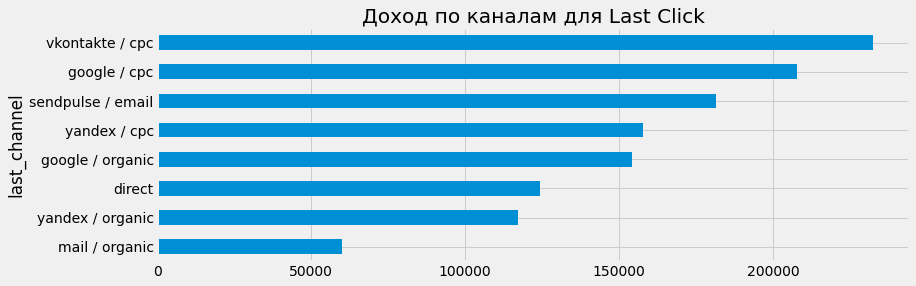

In [25]:
df.groupby('last_channel').profit.sum().sort_values().plot(kind='barh', title='Доход по каналам для Last Click');

#### Сравнение

In [26]:
channel_profit = pd.DataFrame({'channel':df['source_/_medium'].unique()})

# добавляем результаты по каждой модели атрибуции
for x in df.columns[-3:]:
    temp = df.groupby(x)['profit'].sum().reset_index().rename(columns={x:'channel','profit':x+'_profit'})
    channel_profit = channel_profit.merge(temp)
    
channel_profit = channel_profit.set_index('channel')

In [27]:
channel_profit.sum()

first_channel_profit              1234937.03
last_non_direct_channel_profit    1234937.03
last_channel_profit               1234937.03
dtype: float64

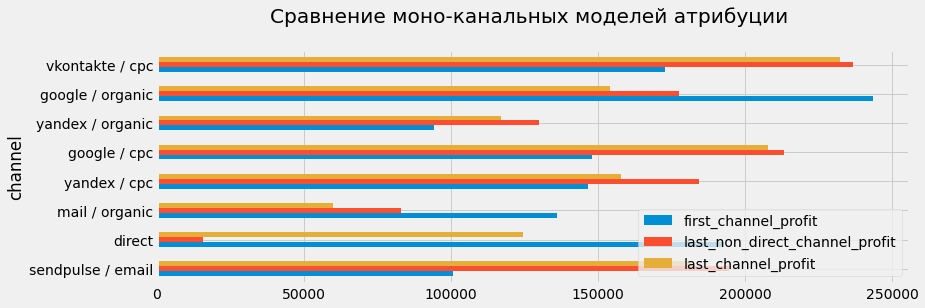

In [28]:
channel_profit.plot(kind='barh', title='Сравнение моно-канальных моделей атрибуции \n');

In [29]:
(channel_profit
 .T
 .style
 .format("{:.0f}")
 .background_gradient(cmap='Blues')
)

channel,sendpulse / email,direct,mail / organic,yandex / cpc,google / cpc,yandex / organic,google / organic,vkontakte / cpc
first_channel_profit,100769,192779,136177,146443,148106,94327,243445,172890
last_non_direct_channel_profit,194562,15517,82920,184243,213268,130040,177565,236822
last_channel_profit,181469,124351,59853,157703,207763,117145,154225,232429


#### Вывод

При анализе модели атрибуции `first_channel_profit` отчетливо видно, что канал `direct` приносит значительный `profit`, что говорит о том, что под данный канал попадают не только прямые заходы но и другие источники. Возможные причиные: 
- отсутствие использование utm-меток для ряда источников, которые не передают реферер (Whatsapp, Telegram, Viber, Skype)
- высокое количество визитов при просмотре через встроенные браузеры Facebook или Telegram

Таким образом, источник `direct` имеет высокое значение, поэтому оценивать эффективность рекламных кампаний по модели атрибуции `last non direct click` некорректно, хоть `yandex / cpc` и получает наибольшую выгоду при модели атрибуции `last_non_direct_channel_profit`.

### Мультиканальные модели атрибуции

#### Linear
Модель атрибуции подразумевает равномерное распределение ценности конверсии между всеми каналами, участвующими в транзакционной цепочке

In [30]:
# рассчитаем количество сессий в каждой транзакционной цепочке

session_count = df.groupby('orders_chain')['client_id'].count().reset_index()
session_count = session_count.rename(columns={'client_id':'chain_size'})
session_count.head()

,orders_chain,chain_size
0,10022,4
1,10048,4
2,10052,7
3,10053,4
4,10054,5


In [31]:
df = df.merge(session_count, on='orders_chain', how='left') # объединяем с исходным датасетом

In [32]:
# распредляем долю profit на каждый из источников в зависимости от количества сессий

df['linear_channel_profit'] = df['profits_chain'] * (1 / df['chain_size'])

df.head()

,client_id,sessiondate,order_id,transaction,source_/_medium,campaign,profit,orders_chain,profits_chain,first_channel,last_non_direct_channel,last_channel,chain_size,linear_channel_profit
0,00039fbdd03f38f626f9b1762e10b31a,2011-04-14,NaN,0.0,sendpulse / email,news,NaN,38117,-128.89,NaN,NaN,sendpulse / email,3,-42.963333
1,00039fbdd03f38f626f9b1762e10b31a,2011-04-17,NaN,0.0,direct,NaN,NaN,38117,-128.89,NaN,NaN,direct,3,-42.963333
2,00039fbdd03f38f626f9b1762e10b31a,2011-04-20,38117,1.0,direct,NaN,-128.89,38117,-128.89,sendpulse / email,sendpulse / email,direct,3,-42.963333
3,00039fbdd03f38f626f9b1762e10b31a,2011-06-05,NaN,0.0,mail / organic,NaN,NaN,43874,-161.21,NaN,NaN,mail / organic,3,-53.736667
4,00039fbdd03f38f626f9b1762e10b31a,2011-06-08,NaN,0.0,yandex / cpc,brand,NaN,43874,-161.21,NaN,NaN,yandex / cpc,3,-53.736667


In [33]:
linear_channel = df.groupby('last_channel')['linear_channel_profit'].sum()
linear_channel

last_channel
direct               165623.516336
google / cpc         171947.700627
google / organic     246470.788675
mail / organic       104042.210680
sendpulse / email    127696.875177
vkontakte / cpc      155580.219110
yandex / cpc         137451.993722
yandex / organic     126123.725673
Name: linear_channel_profit, dtype: float64

#### Time decay

Данная модель атрибуции подразумевает, что самую большую долю ценности получают точки взаимодействия, наиболее близкие по порядковому номеру к совершении к конверсии. Иначе говоря, чем дальше от конверсии по порядковому номеру, тем меньше ценность.

In [34]:
# добавляем номер визита в рамках транзакционной цепочки

df['n_step'] = df.groupby('orders_chain')['client_id'].cumcount() + 1

In [35]:
# создаем лист с перечислением № шага в рамках транзакционной цепочки

list = []
for x in range (df['n_step'].max()):
    list.append(x+1)

list[:3]

[1, 2, 3]

In [36]:
# вычисляем % ценности для каждого источника в рамках данного вида модели атрибуции

df['time_decay_profit'] = df.apply(lambda x: round(x['n_step'] / sum(list[:x['chain_size']]),2), axis=1)
df['time_decay_profit'] = df['time_decay_profit'] * df['profits_chain']

df.head()

,client_id,sessiondate,order_id,transaction,source_/_medium,campaign,profit,orders_chain,profits_chain,first_channel,last_non_direct_channel,last_channel,chain_size,linear_channel_profit,n_step,time_decay_profit
0,00039fbdd03f38f626f9b1762e10b31a,2011-04-14,NaN,0.0,sendpulse / email,news,NaN,38117,-128.89,NaN,NaN,sendpulse / email,3,-42.963333,1,-21.9113
1,00039fbdd03f38f626f9b1762e10b31a,2011-04-17,NaN,0.0,direct,NaN,NaN,38117,-128.89,NaN,NaN,direct,3,-42.963333,2,-42.5337
2,00039fbdd03f38f626f9b1762e10b31a,2011-04-20,38117,1.0,direct,NaN,-128.89,38117,-128.89,sendpulse / email,sendpulse / email,direct,3,-42.963333,3,-64.4450
3,00039fbdd03f38f626f9b1762e10b31a,2011-06-05,NaN,0.0,mail / organic,NaN,NaN,43874,-161.21,NaN,NaN,mail / organic,3,-53.736667,1,-27.4057
4,00039fbdd03f38f626f9b1762e10b31a,2011-06-08,NaN,0.0,yandex / cpc,brand,NaN,43874,-161.21,NaN,NaN,yandex / cpc,3,-53.736667,2,-53.1993


In [37]:
time_decay_channel = df.groupby('source_/_medium')['time_decay_profit'].sum()
time_decay_channel.sort_values()

source_/_medium
mail / organic        95747.3758
yandex / organic     128202.9724
sendpulse / email    137696.6115
yandex / cpc         139920.4990
direct               159965.1228
vkontakte / cpc      164506.1576
google / cpc         175362.2107
google / organic     235390.8928
Name: time_decay_profit, dtype: float64

#### Position based

В рамках модели по 40% ценности присваивается первому и последнему взаимодействиям, а оставшиеся 20% поровну распределяются между остальными.

In [38]:
def position_based_model(size, step):
    if ((step == 1) & (size == 1)):
        value = 1
    elif (step == 1) & (size == 2):
        value = 0.5
    elif (step == 1):
        value = 0.4
    elif (step == 2) & (size == 2):
        value = 0.5
    elif step == size:
        value = 0.4
    else:
        value = round(0.2 / (size - 2), 2)
    return value

In [39]:
# вычисляем % ценности для каждого источника в рамках данного вида модели атрибуции

df['position_based_profit'] = df.apply(lambda x: position_based_model(x['chain_size'], x['n_step']), axis=1)
df['position_based_profit'] = df['profits_chain'] * df['position_based_profit']

In [40]:
position_based_channel = df.groupby('source_/_medium')['position_based_profit'].sum()
position_based_channel.sort_values()

source_/_medium
mail / organic        99073.3365
yandex / organic     114185.2817
sendpulse / email    135313.4214
yandex / cpc         144903.0454
direct               162375.9105
google / cpc         176780.2215
vkontakte / cpc      186532.0147
google / organic     216894.8242
Name: position_based_profit, dtype: float64

#### Сравнение

In [41]:
channel_profit = channel_profit.join(linear_channel).join(time_decay_channel).join(position_based_channel)
channel_profit

,first_channel_profit,last_non_direct_channel_profit,last_channel_profit,linear_channel_profit,time_decay_profit,position_based_profit
channel,,,,,,
sendpulse / email,100769.44,194561.62,181468.53,127696.875177,137696.6115,135313.4214
direct,192778.96,15517.00,124350.83,165623.516336,159965.1228,162375.9105
mail / organic,136176.84,82919.99,59853.13,104042.210680,95747.3758,99073.3365
yandex / cpc,146443.34,184243.14,157703.13,137451.993722,139920.4990,144903.0454
google / cpc,148105.95,213268.27,207763.19,171947.700627,175362.2107,176780.2215
yandex / organic,94326.56,130040.23,117144.63,126123.725673,128202.9724,114185.2817
google / organic,243445.48,177565.08,154224.73,246470.788675,235390.8928,216894.8242
vkontakte / cpc,172890.46,236821.70,232428.86,155580.219110,164506.1576,186532.0147


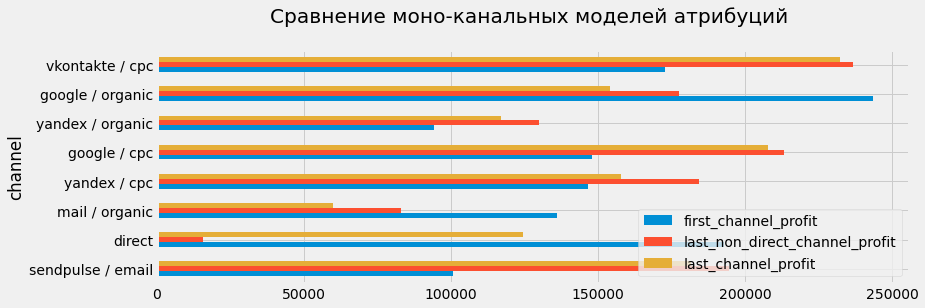

In [42]:
channel_profit[channel_profit.columns[:3]].plot(kind='barh', title='Сравнение моно-канальных моделей атрибуций \n');

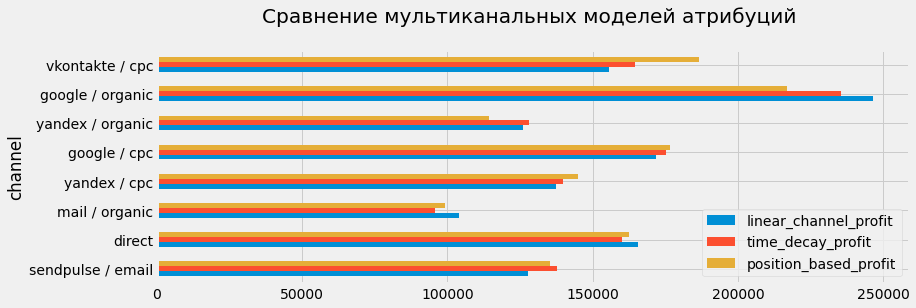

In [43]:
channel_profit[channel_profit.columns[-3:]].plot(kind='barh', title='Сравнение мультиканальных моделей атрибуций \n');

In [44]:
(channel_profit
 .T
 .style
 .format("{:.0f}")
 .background_gradient(cmap='Blues')
)

channel,sendpulse / email,direct,mail / organic,yandex / cpc,google / cpc,yandex / organic,google / organic,vkontakte / cpc
first_channel_profit,100769,192779,136177,146443,148106,94327,243445,172890
last_non_direct_channel_profit,194562,15517,82920,184243,213268,130040,177565,236822
last_channel_profit,181469,124351,59853,157703,207763,117145,154225,232429
linear_channel_profit,127697,165624,104042,137452,171948,126124,246471,155580
time_decay_profit,137697,159965,95747,139920,175362,128203,235391,164506
position_based_profit,135313,162376,99073,144903,176780,114185,216895,186532


### Итог

Мы сравнили эффективность каналов в разрезе нескольких наиболее популярных моделей атрибуции.
В рамках анализа можно говорить о: 

- Переоценность `vkontakte / cpc` и `google / cpc` при использовании модели атрибуции `last_channel_profit`.
- Недооценность `google / organic`, поскольку данный источник вносит значительный вклад в конверсии, как в роли открывающего канала, так и в роли участвующего в конверсионному пути.
- `direct` по прежнему показывает высокую эффективность. Гипотеза о некорректности данного источника подтверждена.
- `sendpulse / email` входит в ТОП-3 закрывающих каналов, что говорит об эффективности проводимых рассылок

## Постройте график по дням по цене клика для каждой из систем

In [45]:
# поскольку в costs отсутствует информация о кликах, то назначим клики, как подсчет количества client_id для каждого типа кампании

clicks = sessions.groupby(['sessiondate','source_/_medium','campaign'])['client_id'].count().reset_index()
clicks = clicks.rename(columns={'client_id':'clicks'})
clicks.head()

,sessiondate,source_/_medium,campaign,clicks
0,2011-01-01,google / cpc,brand,2
1,2011-01-01,sendpulse / email,promo,2
2,2011-01-01,vkontakte / cpc,brand,3
3,2011-01-01,vkontakte / cpc,not_brand,4
4,2011-01-01,yandex / cpc,brand,3


In [46]:
clicks['source_/_medium'] = clicks['source_/_medium'].str.replace(r' ','_')
clicks.head()

,sessiondate,source_/_medium,campaign,clicks
0,2011-01-01,google_/_cpc,brand,2
1,2011-01-01,sendpulse_/_email,promo,2
2,2011-01-01,vkontakte_/_cpc,brand,3
3,2011-01-01,vkontakte_/_cpc,not_brand,4
4,2011-01-01,yandex_/_cpc,brand,3


In [47]:
costs = costs.melt(id_vars=['date','campaign']) # превратим cross table в flat table
costs.columns=['sessiondate','campaign','source_/_medium','costs']
costs.head()

,sessiondate,campaign,source_/_medium,costs
0,2011-08-14,brand,google_/_cpc,90.502456
1,2011-02-25,not_brand,google_/_cpc,135.212379
2,2011-10-28,brand,google_/_cpc,882.106940
3,2011-03-12,not_brand,google_/_cpc,569.433076
4,2011-04-18,brand,google_/_cpc,239.069371


In [48]:
costs = costs.merge(clicks, on=['sessiondate','campaign','source_/_medium']) # объединим информацию о кликах с расходом
costs['cpc'] = costs['costs'] / costs['clicks']

---
Описание google_/_cpc

campaign       brand   not_brand
count     354.000000  347.000000
mean      137.813325  143.379129
std       195.790856  209.615845
min         0.189142    0.509599
25%        30.584019   30.375576
50%        54.696176   53.510961
75%       138.236199  134.990523
max       898.099042  921.064926
---
AxesSubplot(0.08,0.07;0.87x0.81)
---
Описание yandex_/_cpc

campaign       brand   not_brand
count     353.000000  352.000000
mean      198.541342  192.341669
std       235.236269  235.393222
min        12.522648   18.053135
25%        59.020570   59.490933
50%        86.600000   83.225169
75%       244.161246  214.397428
max       983.639837  997.678537
---
AxesSubplot(0.08,0.07;0.87x0.81)
---
Описание vkontakte_/_cpc

campaign       brand   not_brand
count     344.000000  344.000000
mean      167.870309  165.555657
std       195.825152  202.213366
min        15.285714   14.935142
25%        57.420817   59.078075
50%        83.430361   80.958409
75%       190.940

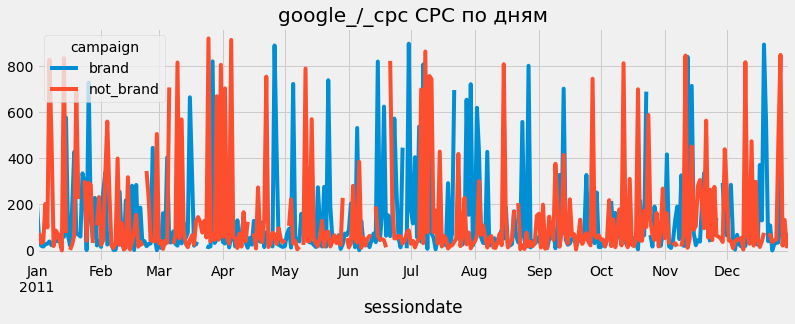

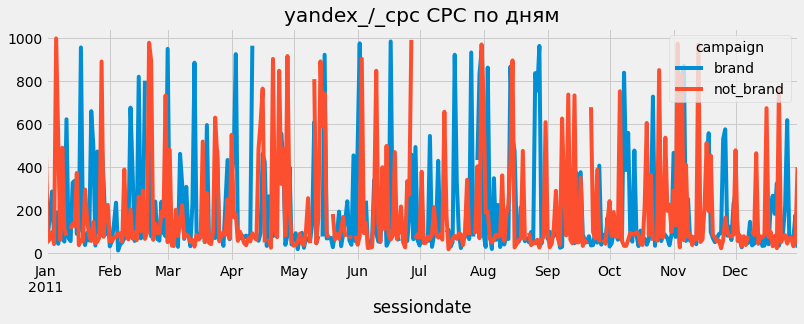

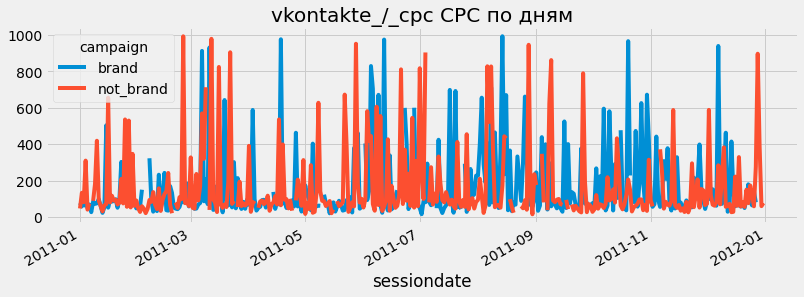

In [49]:
# построим для каждой системы график и описание
for x in ['google_/_cpc','yandex_/_cpc','vkontakte_/_cpc']:
    cpc = costs[(costs['source_/_medium']==x)].pivot_table(index='sessiondate',columns='campaign',values='cpc')
    print('---')
    print('Описание '+x+'\n')
    print(cpc.describe());
    print('---')
    print(cpc.plot(title=x+' CPC по дням'));

### Итог

Самый высокий медианный и средний `CPC` оказался у платной рекламы `yandex_/_cpc`, а самый низким CPC обладает `google_/_cpc`, хотя всем платформам характерен высокий разброс `CPC`.

## Рассчитайте средний ROI для каждой из рекламных систем


In [50]:
channel_profit.index = channel_profit.index.str.replace(r' ', '_')

In [51]:
channel_profit = channel_profit.join(costs.groupby(['source_/_medium'])['costs'].sum()) # добавим информацию о расходах

In [52]:
# рассчитаем ROI для каждой из модели атрибуции

for x in channel_profit.columns[:-1]:
    channel_profit[x+'_roi'] = (channel_profit[x] - channel_profit['costs']) / channel_profit['costs']

In [53]:
# сформируем таблицу только с ROI по платным каналам

channel_roi = channel_profit[~channel_profit['first_channel_profit_roi'].isna()][channel_profit.columns[-6:]]
channel_roi

,first_channel_profit_roi,last_non_direct_channel_profit_roi,last_channel_profit_roi,linear_channel_profit_roi,time_decay_profit_roi,position_based_profit_roi
channel,,,,,,
yandex_/_cpc,-0.445532,-0.302413,-0.402900,-0.479575,-0.470229,-0.451364
google_/_cpc,-0.224591,0.116566,0.087744,-0.099768,-0.081891,-0.074467
vkontakte_/_cpc,-0.267286,0.003656,-0.014961,-0.340648,-0.302819,-0.209473


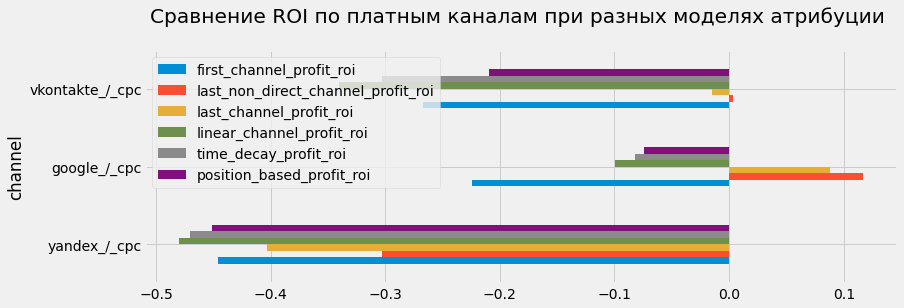

In [54]:
channel_roi.plot(kind='barh', title='Сравнение ROI по платным каналам при разных моделях атрибуции \n');

### Итог

Можно сделать следующий вывод:
- Вне зависимости от модели атрибуции платные каналы показывают низкую эффективность.
- `yandex_/_cpc` является высокоубыточным каналом внезавимости от модели атрибуции.